<a href="https://colab.research.google.com/github/sayakpaul/vit-explain/blob/main/vit_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports

In [48]:
import sys
if "vit-explain" not in sys.path:
    sys.path.append("vit-explain")

import torch
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

## Define Constants

In [49]:
DEVICE = "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

Using cpu


## Utilities

In [50]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

In [51]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

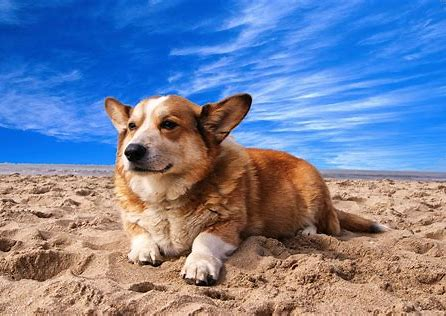

In [52]:
#@title Get an image from the internet

img = Image.open('image.jpg')
img

## Define augmentation transforms and load up a vision transformer

In [53]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [54]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

Using attention_rollout


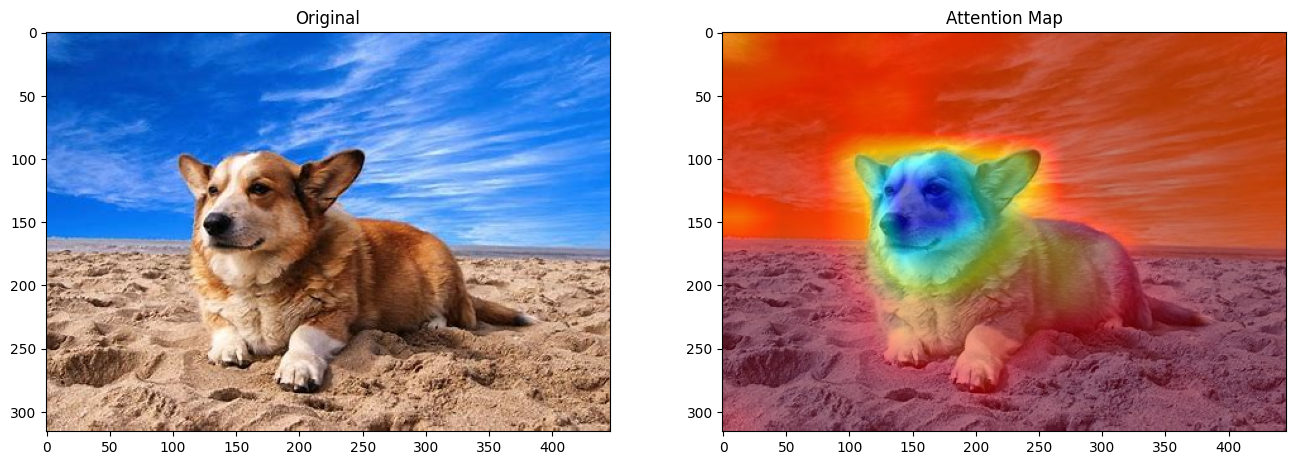

In [55]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("image.jpg", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

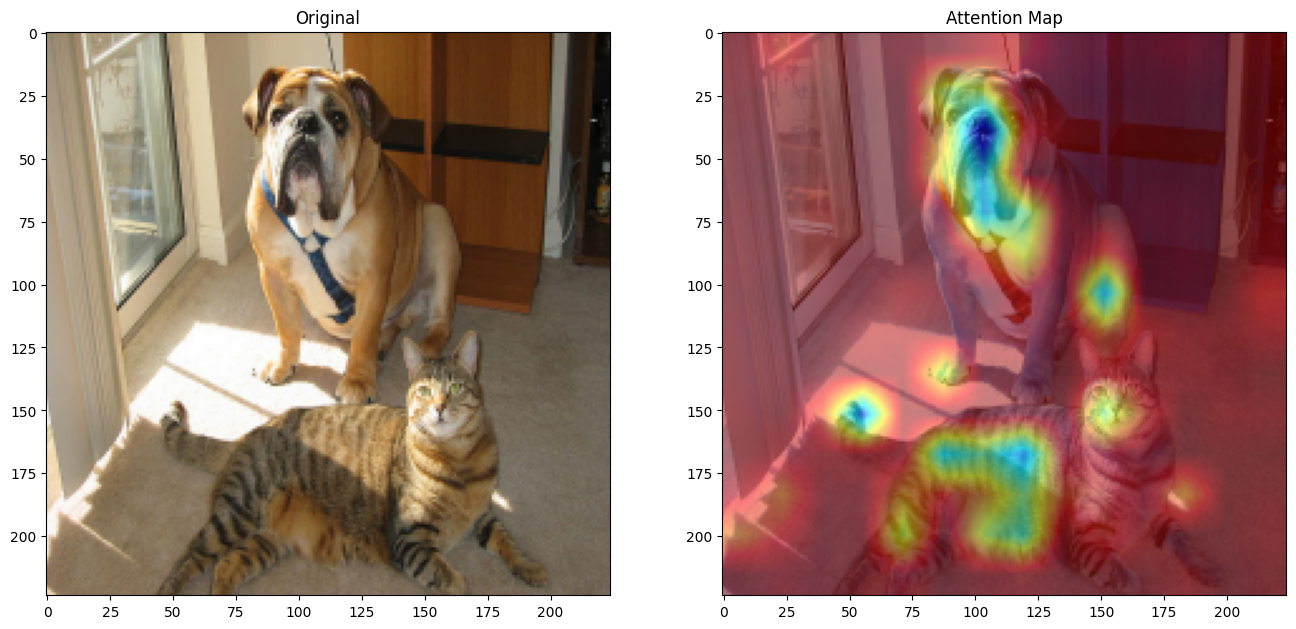

In [68]:
rollout_strategy = "grad_attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]

input_tensor2  = preprocess_image("both.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor2, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
img=Image.open('both.png')
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

In [63]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [69]:
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

scores = model(input_tensor)
print_preds(scores)

0.447 -> ['n02113023', 'Pembroke']
0.261 -> ['n02113186', 'Cardigan']
0.019 -> ['n02115641', 'dingo']
0.007 -> ['n02105412', 'kelpie']
0.004 -> ['n02106662', 'German_shepherd']


c:\Users\mouha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


array([263, 264, 273, 227, 235, 231, 207, 151, 978, 248, 253, 250,  34,
       232, 186, 805,   5, 913, 173, 977, 249, 247, 775, 147, 807, 230,
       417,  43,  36, 722, 908, 863, 895, 403, 225, 976,  48, 162, 437,
       376, 852, 260, 843, 714,  21,  59, 109, 634, 112, 847, 323, 405,
       517,  65, 460, 282, 408, 303, 313, 274, 713, 733, 239, 609, 107,
       974,   2,  33,  39, 666, 710, 144,  92, 677, 936, 701,  42, 755,
        22, 973,  10,   6, 149,  51, 218,  47, 804, 595, 955, 315, 120,
       940, 972, 668,  41, 673, 885, 656, 902, 757, 745, 836, 818, 465,
       719, 672, 146, 574, 328, 354, 294, 174, 618, 277,  71, 475, 296,
       802, 833, 300, 436, 395, 938, 975, 411, 657, 113, 324, 600, 602,
       801,  49, 797, 774, 511, 950, 942, 575, 983, 420,  14,  78, 271,
       704, 792, 421, 119, 864, 855, 103,   3, 832, 540, 728, 870, 129,
       386, 311, 111, 817, 554, 730, 649, 480,  35, 645, 660, 961, 851,
       993, 760, 700, 726,  64,  73, 125, 951, 241, 837, 935, 98